# 7. Toy-Based Inference

**Pedagogical context.** This notebook covers the Monte Carlo approach to
hypothesis testing, corresponding to Cowan's Lecture 5 (Monte Carlo
methods) and Prosper's frequentist inference lectures when applied to
small-sample problems. The asymptotic approximations from the CCGV paper
are exact only in the large-sample limit. When bins have few expected
events, the test statistic distributions can deviate substantially from
their asymptotic forms, and numerical simulation (toy experiments) is
needed.

The procedure is conceptually simple. Generate many pseudo-datasets under
each hypothesis by sampling nuisance parameters from their constraints,
computing expected yields, and drawing Poisson counts. Evaluate the test
statistic on each pseudo-dataset to build the distribution numerically.
Then compute p-values as tail fractions of the empirical distribution.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({"font.size": 12, "figure.facecolor": "white"})

from histimator import Histogram, Sample, Channel, Model
from histimator.likelihood import fit
from histimator.test_statistics import compute_qtilde_mu
from histimator.cls import compute_asimov_sigma, cls_observed, upper_limit_cls
from histimator.toys import (
    sample_nuisance_parameters, generate_toy_data,
    toy_cls, toy_cls_limit,
)

## 7.1 Generating pseudo-data

The first step is drawing nuisance parameter values from their constraint
distributions, then computing the expected yields at those values, and
finally drawing Poisson counts from those yields. This is the standard
frequentist toy procedure: the nuisance parameters are treated as random
variables whose prior is the constraint function.

In [2]:
# Build a low-statistics model where asymptotics are suspect
edges = np.array([0.0, 1.0, 2.0, 3.0])
signal = Sample("signal", Histogram([1.0, 3.0, 1.0], edges))
signal.add_normfactor("mu", nominal=1.0, bounds=(0.0, 10.0))

background = Sample("background", Histogram([4.0, 5.0, 3.0], edges))
background.add_normsys("bkg_norm", lo=0.85, hi=1.15)

np.random.seed(99)
true_exp = 1.0 * signal.histogram.values + background.histogram.values
data = np.random.poisson(true_exp.astype(int))

ch = Channel("SR")
ch.add_sample(signal)
ch.add_sample(background)
ch.set_data(data)

model = Model("toys_demo")
model.add_channel(ch)

print(f"Expected events per bin: {true_exp}")
print(f"Observed data:           {data}")
print(f"Total expected: {true_exp.sum():.0f} (low-statistics regime)")

Expected events per bin: [5. 8. 4.]
Observed data:           [5 3 8]
Total expected: 17 (low-statistics regime)


In [3]:
# Sample nuisance parameters and generate toy data
rng = np.random.default_rng(42)
for i in range(5):
    nps = sample_nuisance_parameters(model, rng)
    params = {"mu": 1.0}
    params.update(nps)
    toy = generate_toy_data(model, params, rng)
    print(f"  Toy {i}: NPs={nps}, data={toy}")

  Toy 0: NPs={'bkg_norm': 0.30471707975443135}, data=[7. 9. 7.]
  Toy 1: NPs={'bkg_norm': 0.36544406436407834}, data=[6. 8. 5.]
  Toy 2: NPs={'bkg_norm': 0.6789135630718949}, data=[ 2. 10.  3.]
  Toy 3: NPs={'bkg_norm': -0.46235179266456716}, data=[4. 9. 3.]
  Toy 4: NPs={'bkg_norm': 0.01249411872768743}, data=[4. 9. 3.]


## 7.2 Building test statistic distributions

To compute a toy-based p-value at a given $\mu_{\text{test}}$, we need
the distribution of $\tilde{q}_\mu$ under both hypotheses. For each toy
under the signal-plus-background hypothesis, we set $\mu = \mu_{\text{test}}$,
sample NPs, generate data, and compute $\tilde{q}_\mu$. Under the
background-only hypothesis, we set $\mu = 0$.

In [4]:
# Generate test statistic distributions (small n_toys for speed)
n_toys = 200
mu_test = 2.0
rng = np.random.default_rng(7)

q_sb = []  # test stats under s+b
q_b = []   # test stats under b-only

from histimator.channels import Channel as Ch
from histimator.model import Model as Mod

for i in range(n_toys):
    # s+b toy
    nps = sample_nuisance_parameters(model, rng)
    params_sb = {"mu": mu_test}
    params_sb.update(nps)
    toy_data = generate_toy_data(model, params_sb, rng)

    # Build toy model
    toy_ch = Ch("SR")
    for s in ch.samples:
        toy_ch.add_sample(s)
    toy_ch.set_data(toy_data)
    toy_model = Mod("toy")
    toy_model.add_channel(toy_ch)

    qt, _ = compute_qtilde_mu(toy_model, "mu", mu_test)
    q_sb.append(qt)

    # b-only toy
    nps_b = sample_nuisance_parameters(model, rng)
    params_b = {"mu": 0.0}
    params_b.update(nps_b)
    toy_data_b = generate_toy_data(model, params_b, rng)

    toy_ch_b = Ch("SR")
    for s in ch.samples:
        toy_ch_b.add_sample(s)
    toy_ch_b.set_data(toy_data_b)
    toy_model_b = Mod("toy")
    toy_model_b.add_channel(toy_ch_b)

    qt_b, _ = compute_qtilde_mu(toy_model_b, "mu", mu_test)
    q_b.append(qt_b)

print(f"Generated {n_toys} toys under each hypothesis.")
print(f"Mean q_tilde under s+b: {np.mean(q_sb):.3f}")
print(f"Mean q_tilde under b:   {np.mean(q_b):.3f}")

Generated 200 toys under each hypothesis.
Mean q_tilde under s+b: 0.488
Mean q_tilde under b:   5.816


Observed q_tilde at mu=2.0: 3.247


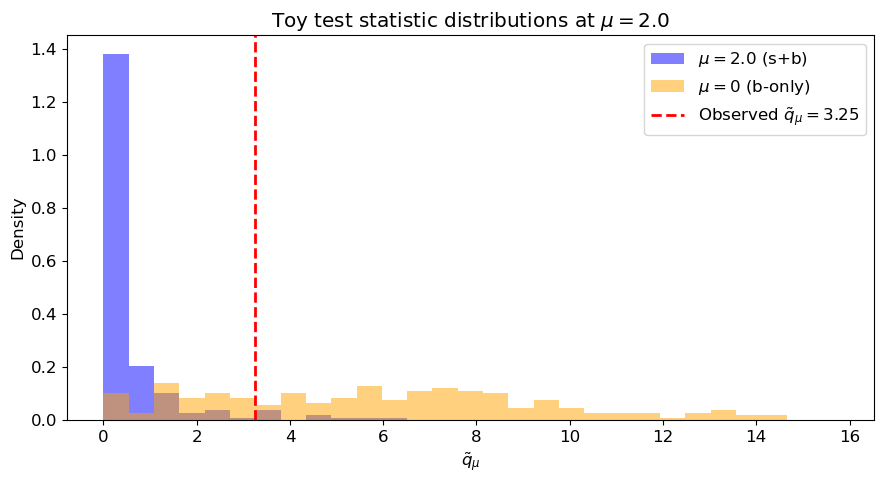

Toy CLsb = 0.045, CLb = 0.710, CLs = 0.063


In [5]:
# Compute observed test statistic
q_obs, mu_hat_obs = compute_qtilde_mu(model, "mu", mu_test)
print(f"Observed q_tilde at mu={mu_test}: {q_obs:.3f}")

# Plot distributions
fig, ax = plt.subplots(figsize=(9, 5))
bins = np.linspace(0, max(max(q_sb), max(q_b), q_obs) * 1.1, 30)
ax.hist(q_sb, bins=bins, alpha=0.5, density=True, color="blue",
        label=rf"$\mu = {mu_test}$ (s+b)")
ax.hist(q_b, bins=bins, alpha=0.5, density=True, color="orange",
        label=r"$\mu = 0$ (b-only)")
ax.axvline(q_obs, color="red", linewidth=2, ls="--",
           label=rf"Observed $\tilde{{q}}_{{\mu}} = {q_obs:.2f}$")

# Toy-based p-values
clsb_toy = np.mean(np.array(q_sb) >= q_obs)
clb_toy = np.mean(np.array(q_b) >= q_obs)
cls_toy_val = clsb_toy / clb_toy if clb_toy > 0 else 0
ax.set_xlabel(r"$\tilde{q}_\mu$")
ax.set_ylabel("Density")
ax.set_title(rf"Toy test statistic distributions at $\mu = {mu_test}$")
ax.legend()
plt.tight_layout()
plt.show()

print(f"Toy CLsb = {clsb_toy:.3f}, CLb = {clb_toy:.3f}, CLs = {cls_toy_val:.3f}")

## 7.3 The toy_cls convenience function

Histimator provides `toy_cls` to automate the procedure above. It
handles the toy loop, model reconstruction, and p-value calculation
internally.

In [6]:
cls_val = toy_cls(model, "mu", mu_test=2.0, n_toys=300, seed=7)
print(f"toy_cls at mu=2.0: {cls_val:.3f}")

# Compare with asymptotic
cls_asymp = cls_observed(model, "mu", 2.0)
print(f"Asymptotic CLs:    {cls_asymp:.3f}")

toy_cls at mu=2.0: 0.052
Asymptotic CLs:    0.052


## 7.4 Toy-based upper limit

The `toy_cls_limit` function scans $\mu$ and finds where the toy-based
CLs crosses 0.05. This is computationally expensive (it runs the full
toy loop at each scan point) but gives the correct answer when
asymptotics fail.

In [7]:
# Toy-based limit (small n_toys for speed)
toy_limit = toy_cls_limit(model, "mu", n_toys=150, seed=42,
                          scan_points=8, scan_range=(0.1, 5.0))
print(f"Toy-based 95% CL limit: mu < {toy_limit:.3f}")

# Asymptotic limit for comparison
obs_asymp, exp_asymp = upper_limit_cls(model, "mu")
print(f"Asymptotic limit:       mu < {obs_asymp:.3f}")
print(f"\nIn this low-statistics regime, the two may differ noticeably.")

Toy-based 95% CL limit: mu < 2.575
Asymptotic limit:       mu < 2.021

In this low-statistics regime, the two may differ noticeably.


## 7.5 When to use toys vs asymptotics

The asymptotic approximation is reliable when each bin has roughly
10 or more expected events. Below that, the test statistic distribution
deviates from the analytic form, and toy-based inference gives more
accurate coverage. The cost is computation time: a typical toy-based
limit with 1000 toys at 20 scan points requires 40,000 fits.

In practice, analysts often use asymptotics for fast iteration during
analysis development and switch to toys for the final result if any
signal or control region has low statistics.

## Exercises

**Exercise 7.1.** Increase the background yields by a factor of 10
(from the model in this notebook) so that each bin has 40 or more
expected events. Recompute both the toy-based and asymptotic CLs limits.
Verify that they converge.

**Exercise 7.2.** For the low-statistics model, generate 500 toys under
the background-only hypothesis at the observed limit value. Plot the
distribution of CLs values across toys and compute the coverage: what
fraction of toys have CLs < 0.05? The target is 5%.

**Exercise 7.3.** Using `generate_toy_data`, simulate 1000
pseudo-experiments under the best-fit hypothesis. For each, compute
the goodness-of-fit chi-squared (sum of $(n_i - \nu_i)^2 / \nu_i$).
Plot the distribution and overlay the theoretical $\chi^2(k)$
distribution for the appropriate degrees of freedom.

## References

G. Cowan, *Statistical Data Analysis*, Lecture 5: The Monte Carlo method.

H. Prosper, "Statistics in Particle Physics", Lectures 6 through 9.

G. Cowan et al., arXiv:1007.1727, Section 4: Toy Monte Carlo.